In [1]:

from scipy.optimize import minimize
from qiskit import *
from qiskit.tools.monitor import job_monitor
import numpy as np
from scipy.optimize import minimize
from pylab import *

In [126]:
bit = ['0','1']
dic = []
for i in bit:
    for j in bit:
        for k in bit:
            dic.append(i+j+k)
dic

['000', '001', '010', '011', '100', '101', '110', '111']

In [118]:
# 1. Quantum_module_Z caculate expectation energy for terms of sigma z 
def module_Z(teta):
    q = QuantumRegister(3)
    c = ClassicalRegister(3)
    circuit = QuantumCircuit(q, c)

    # quantum state preparation
    q = circuit.qregs[0]
 
    circuit.ry(teta[0], 0)
    circuit.cry(teta[1], 0, 1)
    circuit.x(0)

    circuit.cry(teta[2], 0, 1)
    circuit.x(0)
    circuit.append(ccry(teta[3]),[q for q in range(3)])

    circuit.x(1)
    circuit.append(ccry(teta[4]),[q for q in range(3)])
    circuit.x(0)
    circuit.x(1)
    circuit.append(ccry(teta[5]),[q for q in range(3)])
    circuit.x(1)
    circuit.append(ccry(teta[6]),[q for q in range(3)])
    circuit.x(0)
    circuit.x(1)

   
    
    
   
    circuit.measure(range(3),range(3))
# Executing the circuit by qasm_simulation to caculate energy from result.get(counts)    
    shots = 8192
    backend = BasicAer.get_backend('qasm_simulator')
    result = execute(circuit, backend, shots=shots).result()
    counts = result.get_counts()
    
# get full possible keys for counts otherwise we might encounter KeyError where we count nothing for a key
# Remember dic is the list that contain all 2^4=16 possible keys, appending key for count where key in dic but not in count     
    for i in dic:
        if i not in counts:
            counts[i] = 0
# function to calculate probability
    def prob(a,b):
        e = 0
        for i in counts.keys():
            if i[a] == i[b]:
                e += counts[i]
            else:
                e -= counts[i]
        return e/shots

    # expectation value of energy estimation from counts
    E_J = -(prob(0,1) + prob(1,2) + prob(2,0))
    return E_J
# 2. Quantum_module_X caculate expectation energy for terms of sigma x
def module_X(teta):
    q = QuantumRegister(3)
    c = ClassicalRegister(3)
    circuit = QuantumCircuit(q, c)

    # quantum state preparation
    q = circuit.qregs[0]
    circuit.ry(teta[0], 0)
    circuit.cry(teta[1], 0, 1)
    circuit.x(0)

    circuit.cry(teta[2], 0, 1)
    circuit.x(0)
    circuit.append(ccry(teta[3]),[q for q in range(3)])

    circuit.x(1)
    circuit.append(ccry(teta[4]),[q for q in range(3)])
    circuit.x(0)
    circuit.x(1)
    circuit.append(ccry(teta[5]),[q for q in range(3)])
    circuit.x(1)
    circuit.append(ccry(teta[6]),[q for q in range(3)])
    circuit.x(0)
    circuit.x(1)

   # measurement 
# Add Hadamard gate before put measurement gate to change measurement axis from z to x 
    circuit.h(q[0])
    circuit.h(q[1])
    circuit.h(2)
   
    circuit.measure(range(3), range(3))
    
# Executing the circuit by qasm_simulation to caculate energy from result.get(counts)    

    shots = 8192
    backend = BasicAer.get_backend('qasm_simulator')
    result = execute(circuit, backend, shots=shots).result()
    counts = result.get_counts()

# get full possible keys for counts otherwise we might encounter KeyError where we count nothing for a key
# Remember dic is the list that contain all 2^4=16 possible keys, appending key for count where key in dic but not in count 
    
    for i in dic:
        if i not in counts:
            counts[i] = 0
# function to calculate probability
    def prob(j):
        e = 0
        for i in counts.keys():
            if i[j] == '0':
                e += counts[i]
            else:
                e -= counts[i]
        return e/shots 
# expectation value estimation from counts

    E_Z = -(prob(0)+prob(1)+prob(2))
    return E_Z

# expectation value total 
def vqe(teta):
    # Summing the measurement results
    classical_adder = module_Z(teta) + h * module_X(teta)
    return classical_adder

In [115]:
h = 2
vqe(teta=[np.pi/6]*7)

-4.18017578125

In [120]:
teta0=[np.pi/8]*7
tol = 1e-3 
h = 2
vqe_res = minimize(vqe, teta0 , method="COBYLA", tol=tol)
vqe_res

     fun: -5.7529296875
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 64
  status: 1
 success: True
       x: array([0.97745097, 1.05923466, 0.87926456, 0.51001709, 1.55606468,
       0.73802307, 0.94117116])

In [127]:
# from numpy import random
# l = np.pi*random.rand()
teta0=[np.pi/6]*7
tol = 1e-3 # tolerance for optimization precision.
# Get expectation energy by optimization with corresponding h = 0.1, 0.2,..., 2.9, 3. 
y_vqe = []
for k in range(0,20):
    h = k/10
    vqe_result = minimize(vqe, teta0 , method="COBYLA", tol=tol)
    y_vqe.append(vqe_result.fun)

In [141]:
z = [-3., -3.00788, -3.03303, -3.07764, -3.14356, -3.23205, -3.34356, 
-3.47764, -3.63303, -3.80788, -4., -4.20713, -4.42711, -4.65797, 
-4.898, -5.14575, -5.4, -5.65973, -5.9241, -6.19242]

In [140]:
z_mean = np.array(z)/3

Text(0.5, 1.0, 'VQE vs Exact Diagonal')

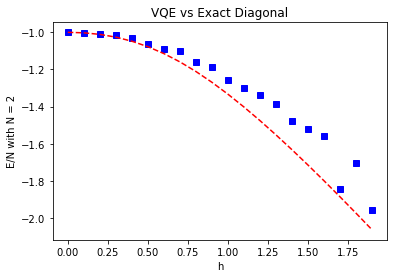

In [142]:
y_mean = np.array(y_vqe)/3

x = []
for k in range(0,20):
    x.append(k/10)

plot(x,y_mean,'bs', label='VQE')
plot(x,z_mean, 'r--',label='Exact')

plt.xlabel('h')
plt.ylabel('E/N with N = 2')
plt.title('VQE vs Exact Diagonal')

In [133]:
x = []
for k in range(0,20):
    x.append(k/10)
len(x)

20

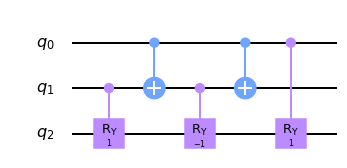

In [30]:
theta=1
qc = QuantumCircuit(3)
qc.cry(theta, 1, 2)
qc.cx(0,1)
qc.cry(-theta, 1, 2)
qc.cx(0,1)
qc.cry(theta, 0, 2)
qc.draw('mpl')

In [95]:
def ccry(theta):
    qc = QuantumCircuit(3)
    qc.cry(theta/2, 1, 2)
    qc.cx(0,1)
    qc.cry(-theta/2, 1, 2)
    qc.cx(0,1)
    qc.cry(theta/2, 0, 2)
    U = qc.to_gate()
    qc.name = 'CCRY'
    return U

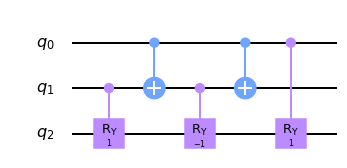

In [92]:
qc = QuantumCircuit(3)
qc.cry(theta, 1, 2)
qc.cx(0,1)
qc.cry(-theta, 1, 2)
qc.cx(0,1)
qc.cry(theta, 0, 2)
U = qc.to_gate
qc.name = 'CCRY'
qc.draw('mpl')

In [94]:
qqc = QuantumCircuit(3)
qqc.x(0)
qqc.x(1)

qqc.append(ccry(2),[q for q in range(3)])
qqc.draw()

┌───┐┌─────────────┐
q_0: ┤ X ├┤0            ├
     ├───┤│             │
q_1: ┤ X ├┤1 circuit195 ├
     └───┘│             │
q_2: ─────┤2            ├
          └─────────────┘

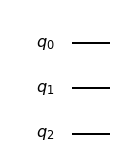

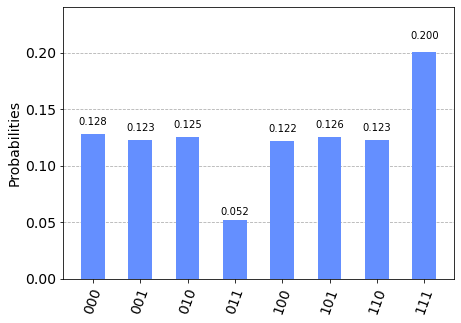

In [123]:
qc = QuantumCircuit(3,3)
qc.h(0)
qc.h(1)
qc.h(2)
qc.append(ccry(np.pi/5),[q for q in range(3)])
circuit = qc
circuit.measure(range(3), range(3))

# Executing the circuit by qasm_simulation to caculate energy from result.get(counts)    

shots = 8192
backend = BasicAer.get_backend('qasm_simulator')
result = execute(circuit, backend, shots=shots).result()
counts = result.get_counts()
plot_histogram(counts)

In [84]:
from qiskit.visualization import plot_histogram

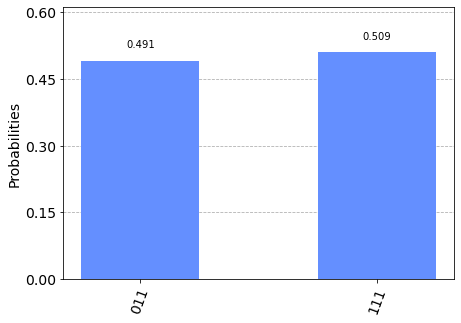

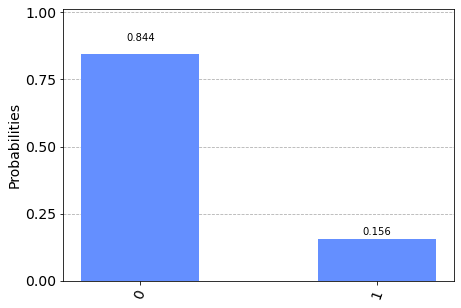

In [100]:
qc = QuantumCircuit(1,1)
qc.ry(np.pi/4,0)

circuit = qc
circuit.measure(range(1), range(1))

# Executing the circuit by qasm_simulation to caculate energy from result.get(counts)    

shots = 8192
backend = BasicAer.get_backend('qasm_simulator')
result = execute(circuit, backend, shots=shots).result()
counts = result.get_counts()
plot_histogram(counts)

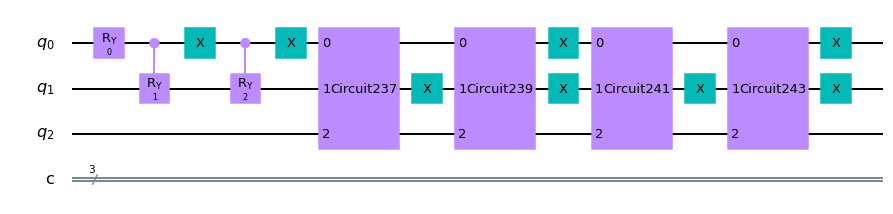

In [109]:
teta = [0,1,2,3,4,5,6]
qc = QuantumCircuit(3,3)
q = circuit.qregs[0]

qc.draw('mpl')

In [125]:
counts?